In [1]:
import ultralytics
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
import math
import pandas as pd
import json
from ultralytics import YOLO

# Obtain Sensor Matrices

In [2]:
with open('dataset_astyx_hires2019/dataset_astyx_hires2019/calibration/000000.json') as f:
   data = json.load(f)
T_lidar_matrix = np.array(data['sensors'][1]['calib_data']['T_to_ref_COS'])
T_camera_matrix = np.array(data['sensors'][2]['calib_data']['T_to_ref_COS'])
K_intrinsic_matrix = np.array(data['sensors'][2]['calib_data']['K'])
inverted_mat = np.linalg.inv(T_camera_matrix)

# Draw Bounding Boxes


0: 224x640 1 car, 1 bus, 894.6ms
Speed: 4.0ms preprocess, 894.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)


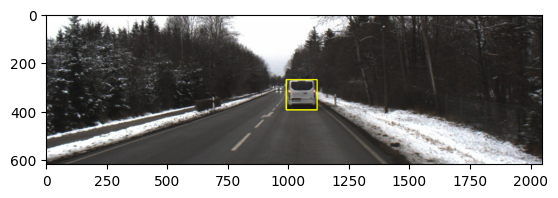

In [24]:
image = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)
model = YOLO('yolov8x.pt')
box = model.predict(image)
boxes = box[0].boxes.xyxy.tolist()
for i in boxes:
    x1,y1 = int(i[0]),int(i[1])
    x2,y2 = int(i[2]),int(i[3])
    result = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))        
    plt.imshow(result)

# Project Radar Point Clouds

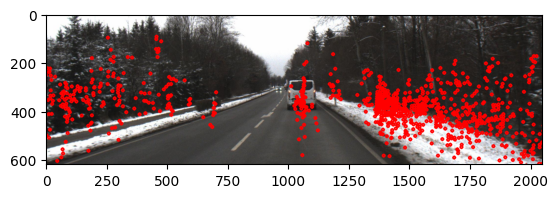

In [27]:
radar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000131.txt',delim_whitespace=True)
image = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)
pixel_points = []
for i in range(len(radar_df)):
    x , y, z = radar_df.iloc[i, :3]
    radar_point = np.array([x,y,z,1])
    camera_point = np.dot(inverted_mat, radar_point.T)  # Transform to Camera Coordinate System
    pixel_point = np.dot(K_intrinsic_matrix, camera_point[:3])  #Transform to Pixel Coordinate System
    homogenous_pixel_coordinates = pixel_point / pixel_point[2]                  #Transform to Homogenous Coordinates
    pixel_points.append(homogenous_pixel_coordinates)
            
for i in pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(255,0,0),5)
plt.imshow(image)

# Project Lidar Point Clouds

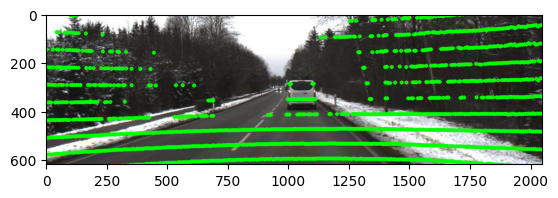

In [149]:
lidar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt',delim_whitespace=True)
image = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)
pixel_points = []
for i in range(len(lidar_df)):
    if lidar_df.iloc[i,0] > 0 :      #Removing points behind the sensor
        x , y, z = lidar_df.iloc[i, :3]
        lidar_point = np.array([x,y,z,1])
        ref_point = np.dot(T_lidar_matrix,lidar_point.T)
        camera_point = np.dot(inverted_mat, ref_point.T)  # Transform to Camera Coordinate System
        pixel_point = np.dot(K_intrinsic_matrix, camera_point[:3])  #Transform to Pixel Coordinate System
        homogenous_pixel_coordinates = pixel_point / pixel_point[2]                  #Transform to Homogenous Coordinates
        pixel_points.append(homogenous_pixel_coordinates)
            
for i in pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(0,255,0),5)
plt.imshow(image)

# Camera and Radar Fusion


0: 224x640 1 car, 1 bus, 929.5ms
Speed: 5.0ms preprocess, 929.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)


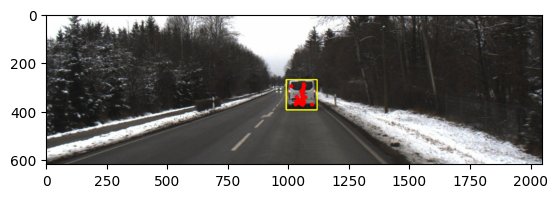

In [150]:
radar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000131.txt',delim_whitespace=True)
image = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)
model = YOLO('yolov8x.pt')
box = model.predict(image)
boxes = box[0].boxes.xyxy.tolist()
pixel_points = []

for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        bw,bh = abs(x1-x2), abs(y1-y2)
        centroid_x, centroid_y = (x1+x2)/2, (y1+y2)/2
        X1,X2 = centroid_x-0.35*(bw), centroid_x + 0.35*(bw)
        Y1,Y2 = centroid_y-0.35*(bh), centroid_y + 0.35*(bh)
        image = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))

for i in range(len(radar_df)):
    x , y, z = radar_df.iloc[i, :3]
    radar_point = np.array([x,y,z,1])
    camera_point = np.dot(inverted_mat, radar_point.T)           # Transform to Camera Coordinate System
    pixel_point = np.dot(K_intrinsic_matrix, camera_point[:3])   # Transform to Pixel Coordinate System
    homogenous_pixel_coordinates = pixel_point / pixel_point[2]  # Transform to Homogenous Coordinates
    x, y = homogenous_pixel_coordinates[0], homogenous_pixel_coordinates[1]
    if x> X1 and x< X2 :
        if y>Y1 and y<Y2:# Normalize by the third row to project onto image plane\n",
            pixel_points.append(homogenous_pixel_coordinates)

for i in pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(255,0,0),5)
plt.imshow(image)

# Camera and Lidar Fusion


0: 224x640 1 car, 1 bus, 767.9ms
Speed: 2.0ms preprocess, 767.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)


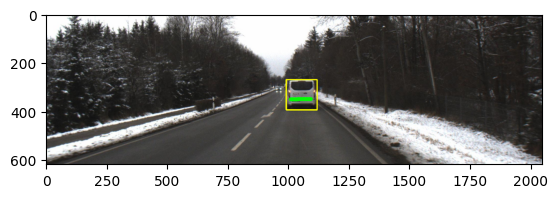

In [152]:
lidar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt',delim_whitespace=True)
image = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)
pixel_points =[]
model = YOLO('yolov8x.pt')
box = model.predict(image)
boxes = box[0].boxes.xyxy.tolist()

for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        bw,bh = abs(x1-x2), abs(y1-y2)
        centroid_x, centroid_y = (x1+x2)/2, (y1+y2)/2
        X1,X2 = centroid_x-0.35*(bw), centroid_x + 0.35*(bw)
        Y1,Y2 = centroid_y-0.35*(bh), centroid_y + 0.35*(bh)
        image = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))

for i in range(len(lidar_df)):
    if lidar_df.iloc[i,0] > 0 :
        x,y,z = lidar_df.iloc[i,:3]
        lidar_point = np.array([x, y, z,1])
        world_point = np.dot(T_lidar_matrix, lidar_point.T)
        camera_point = np.dot(inverted_mat, world_point)  
        pixel_coordinates_homogeneous = np.dot(K_intrinsic_matrix, camera_point[:3].T)
        pixel_coordinates = pixel_coordinates_homogeneous / pixel_coordinates_homogeneous[2]
        x, y = pixel_coordinates[0], pixel_coordinates[1]
    
        if x>= X1 and x<= X2 :
            if y>=Y1 and y<=Y2:
                pixel_points.append(pixel_coordinates)

for i in pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(0,255,0),5)

plt.imshow(image)

# Camera Lidar Radar Fusion

In [57]:
lidar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt',delim_whitespace=True)
radar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000131.txt',delim_whitespace=True)
image    = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)


0: 224x640 1 car, 1 bus, 726.0ms
Speed: 2.0ms preprocess, 726.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)


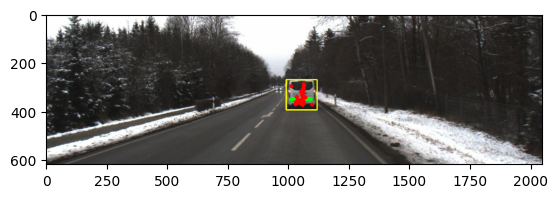

In [58]:
model = YOLO('yolov8x.pt')
box = model.predict(image)
boxes = box[0].boxes.xyxy.tolist()
radar_pixel_points = []
lidar_pixel_points = []

for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        bw,bh = abs(x1-x2), abs(y1-y2)
        centroid_x, centroid_y = (x1+x2)/2, (y1+y2)/2
        X1,X2 = centroid_x-0.35*(bw), centroid_x + 0.35*(bw)
        Y1,Y2 = centroid_y-0.35*(bh), centroid_y + 0.35*(bh)
        image = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))

for i in range(len(radar_df)):
    x , y, z = radar_df.iloc[i, :3]
    radar_point = np.array([x,y,z,1])
    camera_point = np.dot(inverted_mat, radar_point.T)           # Transform to Camera Coordinate System
    pixel_point = np.dot(K_intrinsic_matrix, camera_point[:3])   # Transform to Pixel Coordinate System
    homogenous_pixel_coordinates = pixel_point / pixel_point[2]  # Transform to Homogenous Coordinates
    x, y = homogenous_pixel_coordinates[0], homogenous_pixel_coordinates[1]
    if x> X1 and x< X2 :
        if y>Y1 and y<Y2:# Normalize by the third row to project onto image plane\n",
            radar_pixel_points.append(homogenous_pixel_coordinates)

for i in range(len(lidar_df)):
    if lidar_df.iloc[i,0] > 0 :
        x,y,z = lidar_df.iloc[i,:3]
        lidar_point = np.array([x, y, z,1])
        world_point = np.dot(T_lidar_matrix, lidar_point.T)
        camera_point = np.dot(inverted_mat, world_point)  
        pixel_coordinates_homogeneous = np.dot(K_intrinsic_matrix, camera_point[:3].T)
        pixel_coordinates = pixel_coordinates_homogeneous / pixel_coordinates_homogeneous[2]
        x, y = pixel_coordinates[0], pixel_coordinates[1]
    
        if x>= X1 and x<= X2 :
            if y>=Y1 and y<=Y2:
                lidar_pixel_points.append(pixel_coordinates)


for i in lidar_pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(0,255,0),5)

for i in radar_pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(255,0,0),5)
    
plt.imshow(image)


# Estimate Distance

In [60]:
lidar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt',delim_whitespace=True)
radar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000131.txt',delim_whitespace=True)
image    = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)


0: 224x640 (no detections), 920.5ms
Speed: 4.0ms preprocess, 920.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)


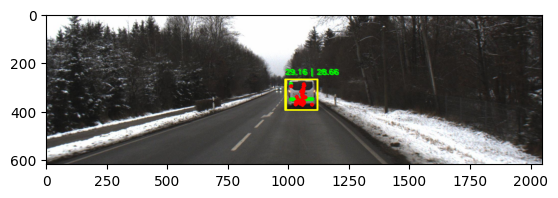

In [154]:
model = YOLO('yolov8x.pt')
box = model.predict(image)
boxes = box[0].boxes.xyxy.tolist()
radar_pixel_points = []
lidar_pixel_points = []

radar_distances = []
filtered_radar_distances = []

lidar_distances = []
filtered_lidar_distances = []

font = cv2.FONT_HERSHEY_SIMPLEX 
org = (x1, y1-20) 
fontScale = 1
color = (0, 255, 0) 
thickness = 2

for i in boxes:
        x1,y1 = int(i[0]),int(i[1])
        x2,y2 = int(i[2]),int(i[3])
        bw,bh = abs(x1-x2), abs(y1-y2)
        centroid_x, centroid_y = (x1+x2)/2, (y1+y2)/2
        X1,X2 = centroid_x-0.35*(bw), centroid_x + 0.35*(bw)
        Y1,Y2 = centroid_y-0.35*(bh), centroid_y + 0.35*(bh)
        image = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))

for i in range(len(radar_df)):
    x , y, z = radar_df.iloc[i, :3]
    radar_point = np.array([x,y,z,1])
    camera_point = np.dot(inverted_mat, radar_point.T)           # Transform to Camera Coordinate System
    pixel_point = np.dot(K_intrinsic_matrix, camera_point[:3])   # Transform to Pixel Coordinate System
    homogenous_pixel_coordinates = pixel_point / pixel_point[2]  # Transform to Homogenous Coordinates
    x, y = homogenous_pixel_coordinates[0], homogenous_pixel_coordinates[1]
    if x> X1 and x< X2 :
        if y>Y1 and y<Y2:
            radar_pixel_points.append(homogenous_pixel_coordinates)
            distance = radar_df.iloc[i,0]
            radar_distances.append(distance)
            

for i in range(len(lidar_df)):
    if lidar_df.iloc[i,0] > 0 :
        x,y,z = lidar_df.iloc[i,:3]
        lidar_point = np.array([x, y, z,1])
        world_point = np.dot(T_lidar_matrix, lidar_point.T)
        camera_point = np.dot(inverted_mat, world_point)  
        pixel_coordinates_homogeneous = np.dot(K_intrinsic_matrix, camera_point[:3].T)
        pixel_coordinates = pixel_coordinates_homogeneous / pixel_coordinates_homogeneous[2]
        x, y = pixel_coordinates[0], pixel_coordinates[1]
        if x>= X1 and x<= X2 :
            if y>=Y1 and y<=Y2:
                lidar_pixel_points.append(pixel_coordinates)
                distance = lidar_df.iloc[i,0]
                lidar_distances.append(distance)

for x in radar_distances :
    if x < np.mean(radar_distances):
        filtered_radar_distances.append(x)

for x in lidar_distances :
    if x < np.mean(lidar_distances):
        filtered_lidar_distances.append(x)

for i in lidar_pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(0,255,0),5)

for i in radar_pixel_points:
     x , y = int(i[0]),int(i[1])
     image = cv2.circle(image,(x,y),5,(255,0,0),5)

image = cv2.putText(image, f'{round(np.mean(filtered_radar_distances),2)} | {round(np.mean(filtered_lidar_distances),2)}' , org, font,  fontScale, color, thickness, cv2.LINE_AA)
plt.imshow(image)

# Data Fusion

In [62]:
def fuse_data(image, radar_data, lidar_data) :
    model = YOLO('yolov8x.pt')
    box = model.predict(image)
    boxes = box[0].boxes.xyxy.tolist()
    radar_pixel_points = []
    lidar_pixel_points = []
    
    radar_distances = []
    filtered_radar_distances = []
    
    lidar_distances = []
    filtered_lidar_distances = []
    
    for i in boxes:
            x1,y1 = int(i[0]),int(i[1])
            x2,y2 = int(i[2]),int(i[3])
            bw,bh = abs(x1-x2), abs(y1-y2)
            centroid_x, centroid_y = (x1+x2)/2, (y1+y2)/2
            X1,X2 = centroid_x-0.35*(bw), centroid_x + 0.35*(bw)
            Y1,Y2 = centroid_y-0.35*(bh), centroid_y + 0.35*(bh)
            image = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))
    
    for i in range(len(radar_df)):
        x , y, z = radar_df.iloc[i, :3]
        radar_point = np.array([x,y,z,1])
        camera_point = np.dot(inverted_mat, radar_point.T)           # Transform to Camera Coordinate System
        pixel_point = np.dot(K_intrinsic_matrix, camera_point[:3])   # Transform to Pixel Coordinate System
        homogenous_pixel_coordinates = pixel_point / pixel_point[2]  # Transform to Homogenous Coordinates
        x, y = homogenous_pixel_coordinates[0], homogenous_pixel_coordinates[1]
        if x> X1 and x< X2 :
            if y>Y1 and y<Y2:
                radar_pixel_points.append(homogenous_pixel_coordinates)
                distance = radar_df.iloc[i,0]
                radar_distances.append(distance)
                
    
    for i in range(len(lidar_df)):
        if lidar_df.iloc[i,0] > 0 :
            x,y,z = lidar_df.iloc[i,:3]
            lidar_point = np.array([x, y, z,1])
            world_point = np.dot(T_lidar_matrix, lidar_point.T)
            camera_point = np.dot(inverted_mat, world_point)  
            pixel_coordinates_homogeneous = np.dot(K_intrinsic_matrix, camera_point[:3].T)
            pixel_coordinates = pixel_coordinates_homogeneous / pixel_coordinates_homogeneous[2]
            x, y = pixel_coordinates[0], pixel_coordinates[1]
            if x>= X1 and x<= X2 :
                if y>=Y1 and y<=Y2:
                    lidar_pixel_points.append(pixel_coordinates)
                    distance = lidar_df.iloc[i,0]
                    lidar_distances.append(distance)
    
    for x in radar_distances :
        if x < np.mean(radar_distances):
            filtered_radar_distances.append(x)
    
    for x in lidar_distances :
        if x < np.mean(lidar_distances):
            filtered_lidar_distances.append(x)
    
    # for i in lidar_pixel_points:
    #      x , y = int(i[0]),int(i[1])
    #      image = cv2.circle(image,(x,y),5,(0,255,0),5)
    
    # for i in radar_pixel_points:
    #      x , y = int(i[0]),int(i[1])
    #      image = cv2.circle(image,(x,y),5,(255,0,0),5)

    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (x1, y1-20) 
    fontScale = 1
    color = (0, 255, 0) 
    thickness = 2

    fused_distance = 0.6*(np.mean(filtered_radar_distances)) + 0.4*(np.mean(filtered_lidar_distances))
    image = cv2.putText(image, f'{round(fused_distance,2)}' , org, font,  fontScale, color, thickness, cv2.LINE_AA)
    
    plt.imshow(image)


0: 256x800 1 Truck, 174.5ms
Speed: 3.0ms preprocess, 174.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 800)


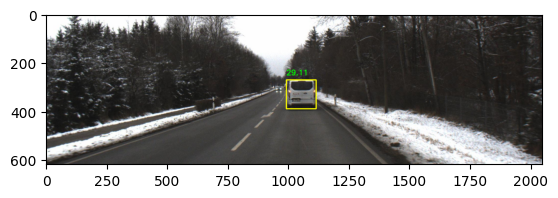

In [61]:
fuse_data(image,radar_df,lidar_df)

# Evaluation

In [26]:
final_distances_cars = []
final_distances_trucks = []
final_distances_buses = []

def fuse_camera_lidar_radar(image, lidar_file, radar_file, ID, vehicle):

    model = YOLO('yolov8x.pt')
    
    if vehicle == 'car' :
        vehicle_class = 2
        
    elif vehicle == 'bus':
        vehicle_class = 5
        
    else :
        vehicle_class = 7

    box = model.predict(image,conf = 0.40 )
    boxes = box[0].boxes.xyxy.tolist()
    
    radar_pixel_points = []
    lidar_pixel_points = []
    
    radar_distances = []
    filtered_radar_distances = []
    
    lidar_distances = []
    filtered_lidar_distances = []
    
    for i in boxes:
            x1,y1 = int(i[0]),int(i[1])
            x2,y2 = int(i[2]),int(i[3])
            bw,bh = abs(x1-x2), abs(y1-y2)
            centroid_x, centroid_y = (x1+x2)/2, (y1+y2)/2
            X1,X2 = centroid_x-0.35*(bw), centroid_x + 0.35*(bw)
            Y1,Y2 = centroid_y-0.35*(bh), centroid_y + 0.35*(bh)
            image = (cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,0),3))
    
    for i in range(len(radar_df)):
        x , y, z = radar_df.iloc[i, :3]
        radar_point = np.array([x,y,z,1])
        camera_point = np.dot(inverted_mat, radar_point.T)           # Transform to Camera Coordinate System
        pixel_point = np.dot(K_intrinsic_matrix, camera_point[:3])   # Transform to Pixel Coordinate System
        homogenous_pixel_coordinates = pixel_point / pixel_point[2]  # Transform to Homogenous Coordinates
        x, y = homogenous_pixel_coordinates[0], homogenous_pixel_coordinates[1]
        if x> X1 and x< X2 :
            if y>Y1 and y<Y2:
                radar_pixel_points.append(homogenous_pixel_coordinates)
                distance = radar_df.iloc[i,0]
                radar_distances.append(distance)
                
    
    for i in range(len(lidar_df)):
        if lidar_df.iloc[i,0] > 0 :
            x,y,z = lidar_df.iloc[i,:3]
            lidar_point = np.array([x, y, z,1])
            world_point = np.dot(T_lidar_matrix, lidar_point.T)
            camera_point = np.dot(inverted_mat, world_point)  
            pixel_coordinates_homogeneous = np.dot(K_intrinsic_matrix, camera_point[:3].T)
            pixel_coordinates = pixel_coordinates_homogeneous / pixel_coordinates_homogeneous[2]
            x, y = pixel_coordinates[0], pixel_coordinates[1]
            if x>= X1 and x<= X2 :
                if y>=Y1 and y<=Y2:
                    lidar_pixel_points.append(pixel_coordinates)
                    distance = lidar_df.iloc[i,0]
                    lidar_distances.append(distance)
    
    for x in radar_distances :
        if x < np.mean(radar_distances):
            filtered_radar_distances.append(x)
    
    for x in lidar_distances :
        if x < np.mean(lidar_distances):
            filtered_lidar_distances.append(x)
    
    # for i in lidar_pixel_points:
    #      x , y = int(i[0]),int(i[1])
    #      image = cv2.circle(image,(x,y),5,(0,255,0),5)
    
    # for i in radar_pixel_points:
    #      x , y = int(i[0]),int(i[1])
    #      image = cv2.circle(image,(x,y),5,(255,0,0),5)

    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (x1, y1-20) 
    fontScale = 1
    color = (0, 255, 0) 
    thickness = 2

    final_distance = 0.6*(np.mean(filtered_radar_distances)) + 0.4*(np.mean(filtered_lidar_distances))
    
    if vehicle == 'car' :
        final_distances_cars.append(final_distance)
        
    elif vehicle == 'truck':
        final_distances_trucks.append(final_distance)
        
    else :
        final_distances_buses.append(final_distance)

    
    image = cv2.putText(image, f'{round(final_distance,2)}' , org, font,  fontScale, color, thickness, cv2.LINE_AA)
    cv2.imwrite(f'Final Distances/{vehicle}/Frame_{ID}.jpg',cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    #plt.imshow(image)

In [125]:
lidar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt',delim_whitespace=True)
radar_df = pd.read_csv('dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000131.txt',delim_whitespace=True)
image    = cv2.cvtColor(cv2.imread('dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg'), cv2.COLOR_BGR2RGB)


0: 256x800 1 Truck, 237.4ms
Speed: 4.0ms preprocess, 237.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 800)


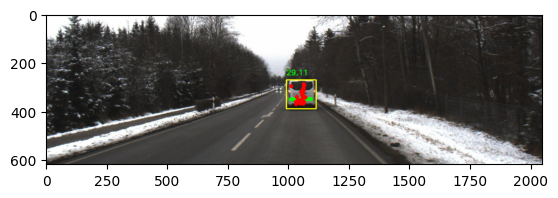

In [126]:
fuse_camera_lidar_radar(image,lidar_df,radar_df,'000131','truck')

In [ ]:
global final_distances_trucks
final_distances_trucks = []
trucks = os.listdir('Trucks')
radar_dir_trucks = []
lidar_dir_trucks = []
IDs_trucks = []
for x in trucks:
    ID = x[:6]
    radar_file = ID + '.txt'
    lidar_file = ID + '.txt'
    IDs_trucks.append(ID)
    radar_dir_trucks.append(radar_file)
    lidar_dir_trucks.append(lidar_file)

for i in range(len(trucks)):
    image = trucks[i]
    lidar_file = lidar_dir_trucks[i]
    radar_file = radar_dir_trucks[i]
    ID = IDs_trucks[i]
    lidar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{lidar_file}',delim_whitespace=True)
    radar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{radar_file}',delim_whitespace=True)
    camera_image_rgb = cv2.cvtColor(cv2.imread(f'dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{image}'), cv2.COLOR_BGR2RGB)
    fuse_camera_lidar_radar_fusion(camera_image_rgb,lidar_df,radar_df,ID,'truck')

In [30]:
truck_frames = os.listdir('Final Frames/Trucks')
truck_actual_distances = []
truck_frame_ids = [x[-10:-4] for x in truck_frames]
i = 0
for x in truck_frame_ids:
    pseudo = []
    comparison = []
    json_file = x + '.json'
    with open(f'dataset_astyx_hires2019/dataset_astyx_hires2019/groundtruth_obj3d/{json_file}') as f:
           gt = json.load(f)
           for x in range(len(gt['objects'])):
               y = round(gt['objects'][x]['center3d'][0],2)
               pseudo.append(y)
           for x in pseudo:
               comparison.append(abs(x-final_distances_trucks[i]))
           index = comparison.index((min(comparison)))
           truck_actual_distances.append(pseudo[index])
    i+=1
truck_errors = []
truck_squared_errors = []

for i in range(len(final_distances_trucks)):
    error = abs(final_distances_trucks[i] - truck_actual_distances[i])
    truck_errors.append(error)
for i in range(len(final_distances_cars)):
    square_error = (final_distances_trucks[i] - truck_actual_distances[i])**2
    truck_squared_errors.append(square_error)
MAE_truck = np.mean(truck_errors)
RMSE_truck = math.sqrt(np.mean(truck_squared_errors))
print(f'MAE = {MAE_truck} | RMSE = {RMSE_truck}')

MAE = 1.691016949152543 | RMSE = 2.072880988677435


In [8]:
cars = os.listdir('Cars')
radar_dir_cars = []
lidar_dir_cars = []
IDs_cars = []
for x in cars:
    ID = x[:6]
    radar_file = ID + '.txt'
    lidar_file = ID + '.txt'
    IDs_cars.append(ID)
    radar_dir_cars.append(radar_file)
    lidar_dir_cars.append(lidar_file)

In [ ]:
global final_distances_cars
final_distances_cars = []
for i in range(len(cars)):
    image = cars[i]
    lidar_file = lidar_dir_cars[i]
    radar_file = radar_dir_cars[i]
    ID = IDs_cars[i]
    lidar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{lidar_file}',delim_whitespace=True)
    radar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{radar_file}',delim_whitespace=True)
    camera_image_rgb = cv2.cvtColor(cv2.imread(f'dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{image}'), cv2.COLOR_BGR2RGB)
    fuse_camera_lidar_radar_fusion(camera_image_rgb,lidar_df,radar_df,ID,'car')

In [31]:
car_frame_ids = []
for x in cars:
    car_frame_ids.append(x[:6])
car_actual_distances = []

i = 0
for x in car_frame_ids:
    pseudo = []
    comparison = []
    json_file = x + '.json'
    with open(f'dataset_astyx_hires2019/dataset_astyx_hires2019/groundtruth_obj3d/{json_file}') as f:
           gt = json.load(f)
           for x in range(len(gt['objects'])):
               y = round(gt['objects'][x]['center3d'][0],2)
               pseudo.append(y)
           for x in pseudo:
               comparison.append(abs(x-final_distances_cars[i]))
           index = comparison.index((min(comparison)))
           car_actual_distances.append(pseudo[index])
    i+=1

car_errors = []
car_squared_errors = []
for i in range(len(final_distances_cars)):
    error = abs(final_distances_cars[i] - car_actual_distances[i])
    car_errors.append(error)
for i in range(len(final_distances_cars)):
    square_error = (final_distances_cars[i] - car_actual_distances[i])**2
    car_squared_errors.append(square_error)
MAE_car = np.mean(car_errors)
RMSE_car = math.sqrt(np.mean(car_squared_errors))
print(f'MAE = {MAE_car} | RMSE = {RMSE_car}')

MAE = 1.470169491525424 | RMSE = 2.289035027240126


In [ ]:
buses = os.listdir('Buses')
final_distances_buses = []
radar_dir_buses = []
lidar_dir_buses = []
IDs_buses = []
for x in buses:
    ID = x[:6]
    radar_file = ID + '.txt'
    lidar_file = ID + '.txt'
    IDs_buses.append(ID)
    radar_dir_buses.append(radar_file)
    lidar_dir_buses.append(lidar_file)

for i in range(len(buses)):
    image = buses[i]
    lidar_file = lidar_dir_buses[i]
    radar_file = radar_dir_buses[i]
    ID = IDs_buses[i]
    lidar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{lidar_file}',delim_whitespace=True)
    radar_df = pd.read_csv(f'dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{radar_file}',delim_whitespace=True)
    camera_image_rgb = cv2.cvtColor(cv2.imread(f'dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{image}'), cv2.COLOR_BGR2RGB)
    fuse_camera_lidar_radar_fusion(camera_image_rgb,lidar_df,radar_df,ID,'bus')

In [32]:
bus_actual_distances = []
bus_frame_ids = []
for x in buses:
    bus_frame_ids.append(x[:6])
bus_actual_distances = []
i = 0
for x in bus_frame_ids:
    pseudo = []
    comparison = []
    json_file = x + '.json'
    with open(f'dataset_astyx_hires2019/dataset_astyx_hires2019/groundtruth_obj3d/{json_file}') as f:
           gt = json.load(f)
           for x in range(len(gt['objects'])):
               y = round(gt['objects'][x]['center3d'][0],2)
               pseudo.append(y)
           for x in pseudo:
               comparison.append(abs(x - final_distances_buses[i]))
           index = comparison.index((min(comparison)))
           bus_actual_distances.append(pseudo[index])
    i+=1

bus_errors = []
bus_squared_errors = []
for i in range(len(final_distances_buses)):
    error = abs(final_distances_buses[i] - bus_actual_distances[i])
    bus_errors.append(error)
for i in range(len(final_distances_buses)):
    square_error = (final_distances_buses[i] - bus_actual_distances[i])**2
    bus_squared_errors.append(square_error)
MAE_bus = np.mean(bus_errors)
RMSE_bus = math.sqrt(np.mean(bus_squared_errors))
print(f'MAE = {MAE_bus} | RMSE = {RMSE_bus}')

MAE = 2.4805882352941175 | RMSE = 2.9647983762415797


In [33]:
average_mae_error = (MAE_car+MAE_bus+MAE_truck) / 3

In [139]:
print(f'Average MAE Error = {round(average_mae_error,2)} meters')

Average MAE Error = 1.88 meters


In [35]:
average_rmse_error = (RMSE_bus+RMSE_car+RMSE_truck) / 3

In [140]:
print(f'Average RMSE Error = {round(average_rmse_error,2)} meters')

Average RMSE Error = 2.44 meters
